# machine learning codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc



In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 70)

In [3]:
# df = pd.read_csv('df_preprocessed.csv')
main_df = pd.read_csv('df_preprocessed_2.csv')

In [4]:
main_df.columns

Index(['budget', 'genres', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration', 'tagline',
       'vote_average', 'num_voted_users', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'budget_categorized',
       'profit', 'profit_categorized', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'other', 'year',
       'years_since_release', 'decade', 'month', 'season',
       'production_companies_list', 'actor_list', 'top actors', 'top_director',
       'language_summarized', 'vote_average_categorized'],
      dtype='object')

In [5]:
main_df['profit_categorized'] = main_df['profit_categorized'].replace({'profit': 1, 'no profit':0})

## Preprocessing

In [6]:
def preprocessing_dataframe(main_df, inputs):
    
    ##### drop extra fatures
    features_list = inputs['features_list']
    df = main_df[features_list]
    
    ##### drop nan values
    df.dropna(inplace=True)
    
    #### one hot encoding
    columns_to_encode = inputs.get('columns_to_dummies')
    df_onehot = pd.get_dummies(df, columns=columns_to_encode, dtype=int)
    df_onehot.head()
    
    #####
    encoder_list = inputs.get('label_encoder_list', None)
    if encoder_list:
        for col in encoder_list:
            # Initialize LabelEncoder
            label_encoder = LabelEncoder()

            # Fit and transform the 'decade' column
            df_onehot[col] = label_encoder.fit_transform(df_onehot[col])

    ##### making categorical list
    
    numerical_list = inputs.get('numerical_list')
    
    categorical_list = []
    for i in list(df_onehot.columns):
        if i not in numerical_list:
            categorical_list.append(i)
    
    #### type correction
    for i in categorical_list:
        df_onehot[i] = df_onehot[i].astype('category')
    
    #### split data to train and test
    X = df_onehot.drop('profit_categorized', axis=1)
    y = df_onehot['profit_categorized']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    
    #### normalize numerical features
    
    # Initialize the scaler
    scaler = StandardScaler()  # or any other scaler you prefer

    # Fit and transform the training data
    X_train[numerical_list] = scaler.fit_transform(X_train[numerical_list])

    # Transform the test data using the scaler fitted on the training data
    X_test[numerical_list] = scaler.transform(X_test[numerical_list])
    
    return X_train, X_test, y_train, y_test
    

# Machine learning functions

## hyperparameters tuning and evaluating model

In [7]:
# Function to perform hyperparameter tuning and return the best parameters
def tune_hyperparameters(model, param_grid, X_train, y_train, cv=5):
    """
    Perform hyperparameter tuning using grid search and return the best parameters.
    
    Args:
    - model: The machine learning model.
    - param_grid: The parameter grid for grid search.
    - X_train: The training features.
    - y_train: The training labels.
    
    Returns:
    - best_params: The best parameters found by grid search.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Function to train the model using the best parameters
def train_model(model, best_params, X_train, y_train):
    """
    Train the model using the best parameters.
    
    Args:
    - model: The machine learning model.
    - best_params: The best parameters obtained from hyperparameter tuning.
    - X_train: The training features.
    - y_train: The training labels.
    
    Returns:
    - model: The trained model.
    """
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and return evaluation metrics.
    
    Args:
    - model: The trained machine learning model.
    - X_test: The test features.
    - y_test: The test labels.
    
    Returns:
    - accuracy: Accuracy of the model.
    - precision: Precision of the model.
    - recall: Recall of the model.
    - f1: F1-score of the model.
    - confusion_mat: Confusion matrix of the model.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    y_prob = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1, confusion_mat, fpr, tpr

# Main function to combine the above functions
def evaluate_model_pipeline(model, param_grid, X_train, X_test, y_train, y_test):
    """
    Main function to perform hyperparameter tuning, model training, and evaluation.
    
    Args:
    - model: The machine learning model.
    - param_grid: The parameter grid for hyperparameter tuning.
    - X_train: The training features.
    - X_test: The test features.
    - y_train: The training labels.
    - y_test: The test labels.
    """
    best_params = tune_hyperparameters(model, param_grid, X_train, y_train)
    trained_model = train_model(model, best_params, X_train, y_train)
    accuracy, precision, recall, f1, confusion_mat, fpr, tpr = evaluate_model(trained_model, X_test, y_test)
    
    print("Best Parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", confusion_mat)

## compare diffrent models

In [8]:
def evaluate_models(models, param_grids, X_train, X_test, y_train, y_test):
    """
    Evaluate multiple models using the evaluate_model_pipeline function and save the results in a dictionary.
    
    Args:
    - models: A dictionary of models where keys are model names and values are model objects.
    - param_grids: A dictionary of parameter grids corresponding to each model.
    - X_train: The training features.
    - X_test: The test features.
    - y_train: The training labels.
    - y_test: The test labels.
    
    Returns:
    - results: A dictionary containing evaluation results for each model.
    """
    results = {}
    for name, model in models.items():
        print(f"Evaluating {name}...")
        param_grid = param_grids[name]
        result = {}
        result['name'] = name
        result['params'] = tune_hyperparameters(model, param_grid, X_train, y_train)
        trained_model = train_model(model, result['params'], X_train, y_train)
        result['model'] = trained_model
        result['accuracy'], result['precision'], result['recall'], result['f1'], result['confusion_matrix'], result['fpr'], result['tpr'] = evaluate_model(trained_model, X_test, y_test)
        results[name] = result
    return results

In [9]:
def plot_metrics_comparison(results):
    """
    Create a bar plot comparing evaluation metrics (Accuracy, Precision, Recall, F1-Score) for multiple models.
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    model_names = list(results.keys())
    num_models = len(model_names)

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Comparison of Evaluation Metrics', fontsize=16)

    for i, metric in enumerate(metrics):
        for j, model_name in enumerate(model_names):
            metric_value = results[model_name][metric.lower()]
            axes[i].bar(j, metric_value, color=['blue', 'green', 'orange', 'red'][j])
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(np.arange(num_models))
        axes[i].set_xticklabels(model_names, rotation=45)
        axes[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, X_test, y_test):
    """
    Plot and compare confusion matrices for multiple models.
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    - X_test: The test features.
    - y_test: The test labels.
    """
    model_names = list(results.keys())

    for model_name in model_names:
        confusion_matrix = results[model_name]['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=np.unique(y_test))
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

    
def plot_roc_auc(results, X_test, y_test):
    """
    plot
    
    Args:
    - results: A dictionary containing evaluation results for each model.
    - X_test: The test features.
    - y_test: The test labels.
    """
    model_names = list(results.keys())
    
    for model_name in model_names:
        fpr = results[model_name]['fpr']
        tpr = results[model_name]['tpr']
        
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{model_name}: (AUC = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Case 1: 
**faetures:**
- 'budget'
- 'duration'
- 'profit_categorized'
- 'years_since_release'
- 'decade'

In [10]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', 'decade']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = ['decade']

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode


X_train, X_test, y_train, y_test = preprocessing_dataframe(main_df, inputs)

X_train.head()

,budget,duration,years_since_release,decade_1980,decade_1990,decade_2000,decade_2010,decade_befor 1980
981,0.508710,0.301280,-1.020781,0,0,0,1,0
2432,-0.726013,-0.645506,-0.452267,0,0,1,0,0
3072,-0.726013,0.585315,-0.289834,0,0,1,0,0
936,0.508710,-0.929542,-0.858348,0,0,0,1,0
1481,0.088904,-0.408810,-0.777132,0,0,0,1,0


In [46]:
# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest - Accuracy: 0.690677966101695
RandomForest - Precision: 0.69216678589919
RandomForest - Recall: 0.690677966101695
RandomForest - F1-Score: 0.685176097060212
RandomForest - Confusion Matrix:
[[239 190]
 [102 413]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6896186440677966
DT - Precision: 0.6894144966564111
DT - Recall: 0.6896186440677966
DT - F1-Score: 0.6859519156155748
DT - Confusion Matrix:
[[249 180]
 [113 402]]

LogisticRegression - Best Parameters: {'C': 100, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.652542372881356
LogisticRegression - Precision: 0.6593433553123735
LogisticRegression - Recall: 0.652542372881356
LogisticRegression - F1-Score: 0.6531229255102103
LogisticRegression - C

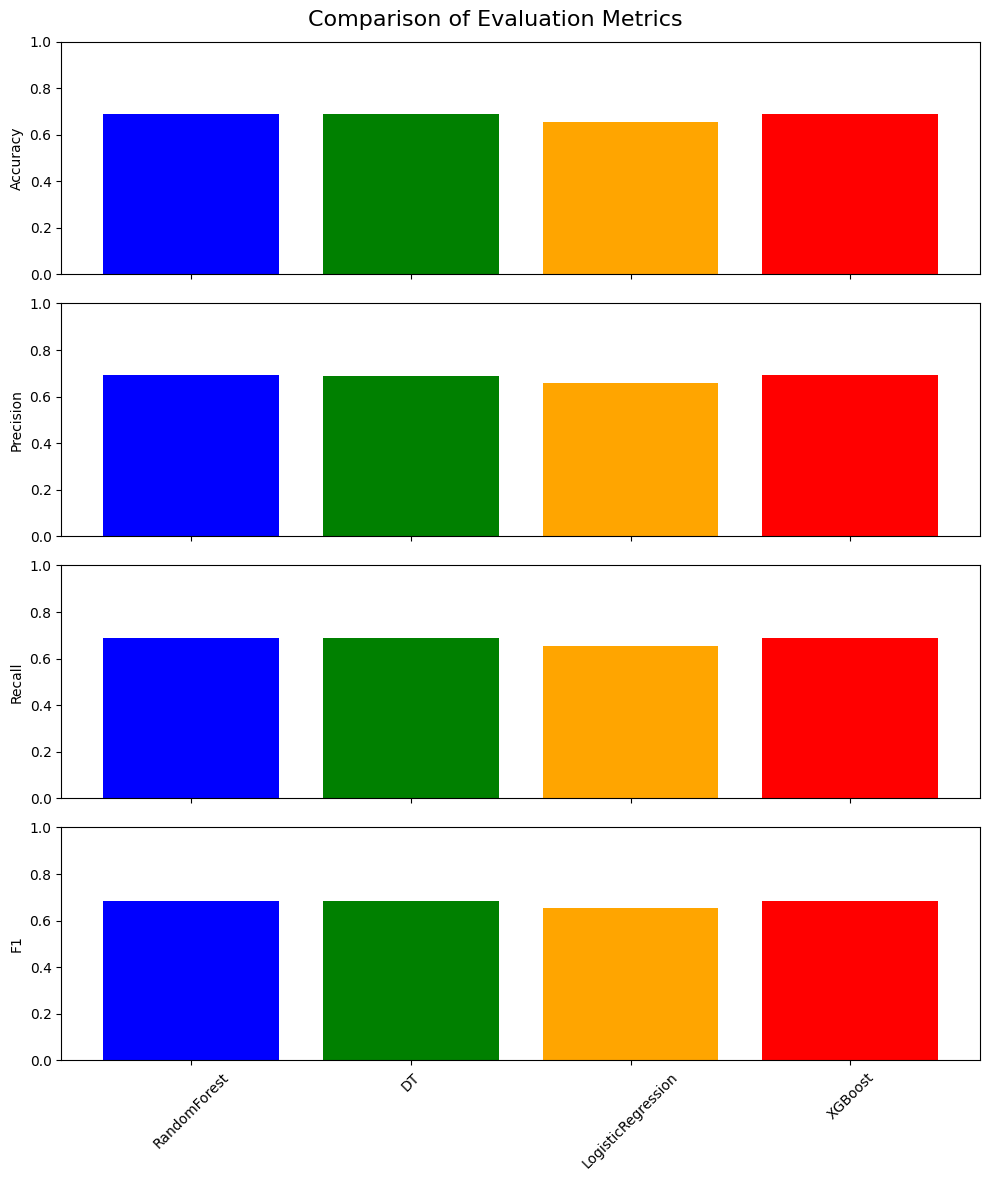

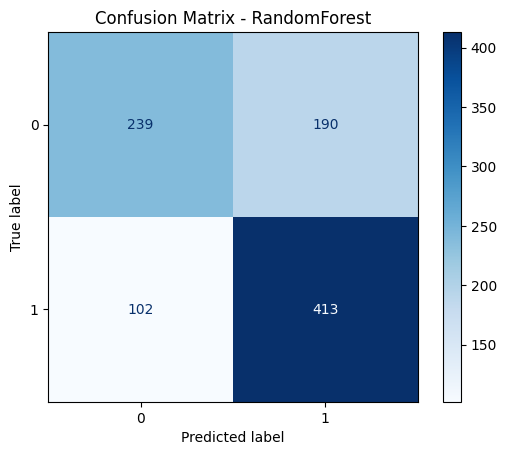

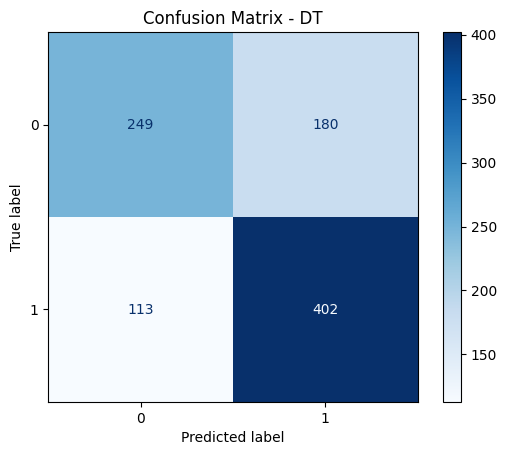

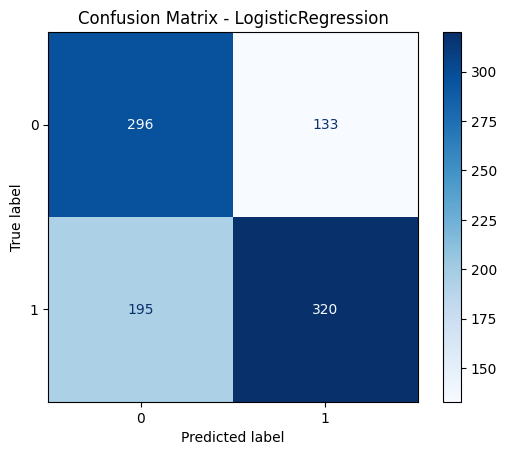

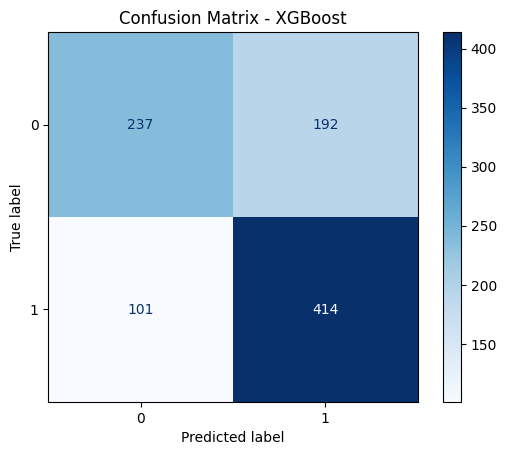

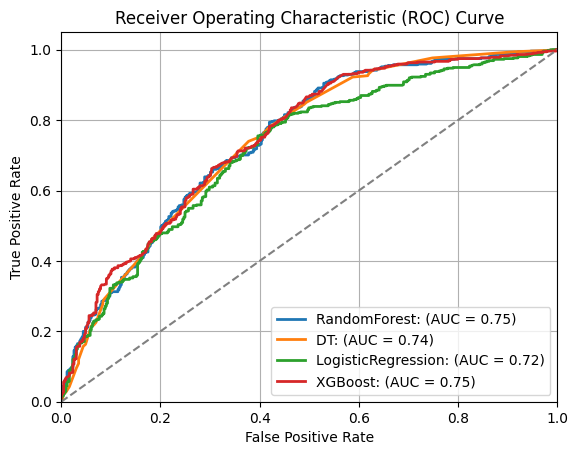

In [47]:
plot_metrics_comparison(results)
plot_confusion_matrices(results, X_test, y_test)
plot_roc_auc(results, X_test, y_test)

# Case 2: 
**faetures:**
- 'budget'
- 'duration'
- 'profit_categorized'
- 'years_since_release'
- 'decade'
- 'season'
- 'top actors'
- 'top_director'
- 'language_summarized'

In [21]:
main_df.columns

Index(['budget', 'genres', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration', 'tagline',
       'vote_average', 'num_voted_users', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'budget_categorized',
       'profit', 'profit_categorized', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'other', 'year',
       'years_since_release', 'decade', 'month', 'season',
       'production_companies_list', 'actor_list', 'top actors', 'top_director',
       'language_summarized', 'vote_average_categorized'],
      dtype='object')

In [37]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', 'decade', 'season',
                 'top actors', 'top_director', 'language_summarized']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = ['decade', 'season']

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode
inputs['label_encoder_list'] = ['language_summarized']

X_train, X_test, y_train, y_test = preprocessing_dataframe(main_df, inputs)

X_train.head()

,budget,duration,years_since_release,top actors,top_director,language_summarized,decade_1980,decade_1990,decade_2000,decade_2010,decade_befor 1980,season_autumn,season_spring,season_summer,season_winter
981,0.508710,0.301280,-1.020781,0,0,0,0,0,0,1,0,0,1,0,0
2432,-0.726013,-0.645506,-0.452267,0,0,0,0,0,1,0,0,0,0,0,1
3072,-0.726013,0.585315,-0.289834,0,0,0,0,0,1,0,0,0,1,0,0
936,0.508710,-0.929542,-0.858348,0,0,0,0,0,0,1,0,0,0,0,1
1481,0.088904,-0.408810,-0.777132,0,0,0,0,0,0,1,0,0,0,1,0


##### training just random forest and analysing the result

In [38]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 200],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [None, 10, 15],
    'max_depth': [None, 6, 8]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)


In [39]:
best_params

{'max_depth': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [40]:
# evaluating on train data
y_pred_train = trained_model.predict(X_train)
print(f"accuracy on train data: {accuracy_score(y_train, y_pred_train)}")
print('train data confusion matrix')
confusion_mat = confusion_matrix(y_train, y_pred_train)
print(confusion_mat)

# evaluating on test data
y_pred_test = trained_model.predict(X_test)
print(f"accuracy on test data: {accuracy_score(y_test, y_pred_test)}")
print('test data confusion matrix')
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

accuracy on train data: 0.7643160127253447
train data confusion matrix
[[1213  567]
 [ 322 1670]]
accuracy on test data: 0.6822033898305084
test data confusion matrix


array([[253, 176],
       [124, 391]], dtype=int64)

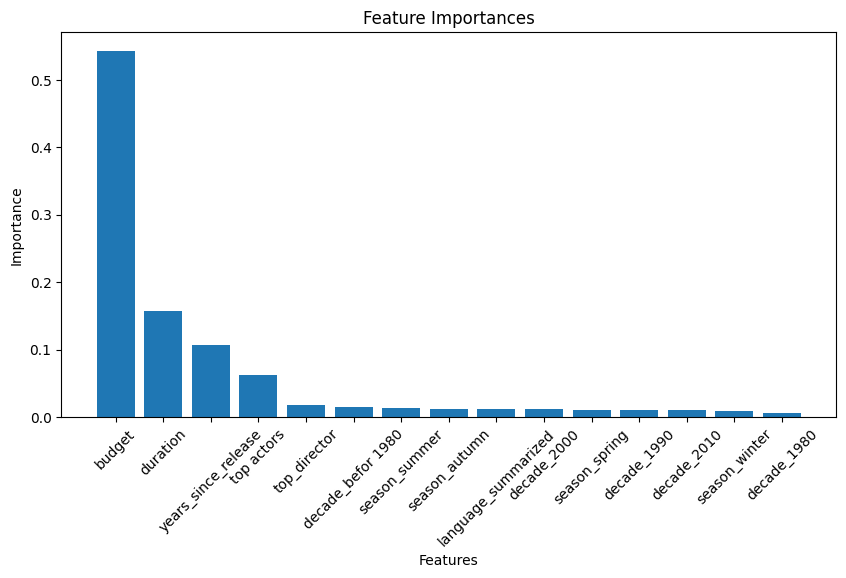

In [41]:
# Feature importances
rf = trained_model
features = list(X_train.columns)

importances = rf.feature_importances_

# Get indices to sort the features by importance
sorted_indices = np.argsort(importances)[::-1]

# Sort features and importances accordingly
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Plotting feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

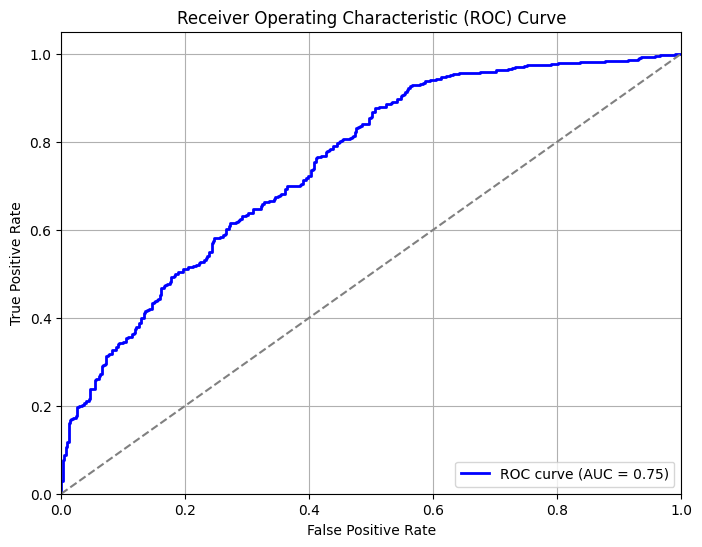

In [42]:
# Calculate ROC curve and AUC
y_prob = trained_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [43]:
# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest - Accuracy: 0.6822033898305084
RandomForest - Precision: 0.6811839461849204
RandomForest - Recall: 0.6822033898305084
RandomForest - F1-Score: 0.6795884037114107
RandomForest - Confusion Matrix:
[[253 176]
 [124 391]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6875
DT - Precision: 0.6866314241833982
DT - Recall: 0.6875
DT - F1-Score: 0.6848593164834282
DT - Confusion Matrix:
[[255 174]
 [121 394]]

LogisticRegression - Best Parameters: {'C': 0.1, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.6567796610169492
LogisticRegression - Precision: 0.6662805545693495
LogisticRegression - Recall: 0.6567796610169492
LogisticRegression - F1-Score: 0.6570200113943883
LogisticRegression - Confusion Matri

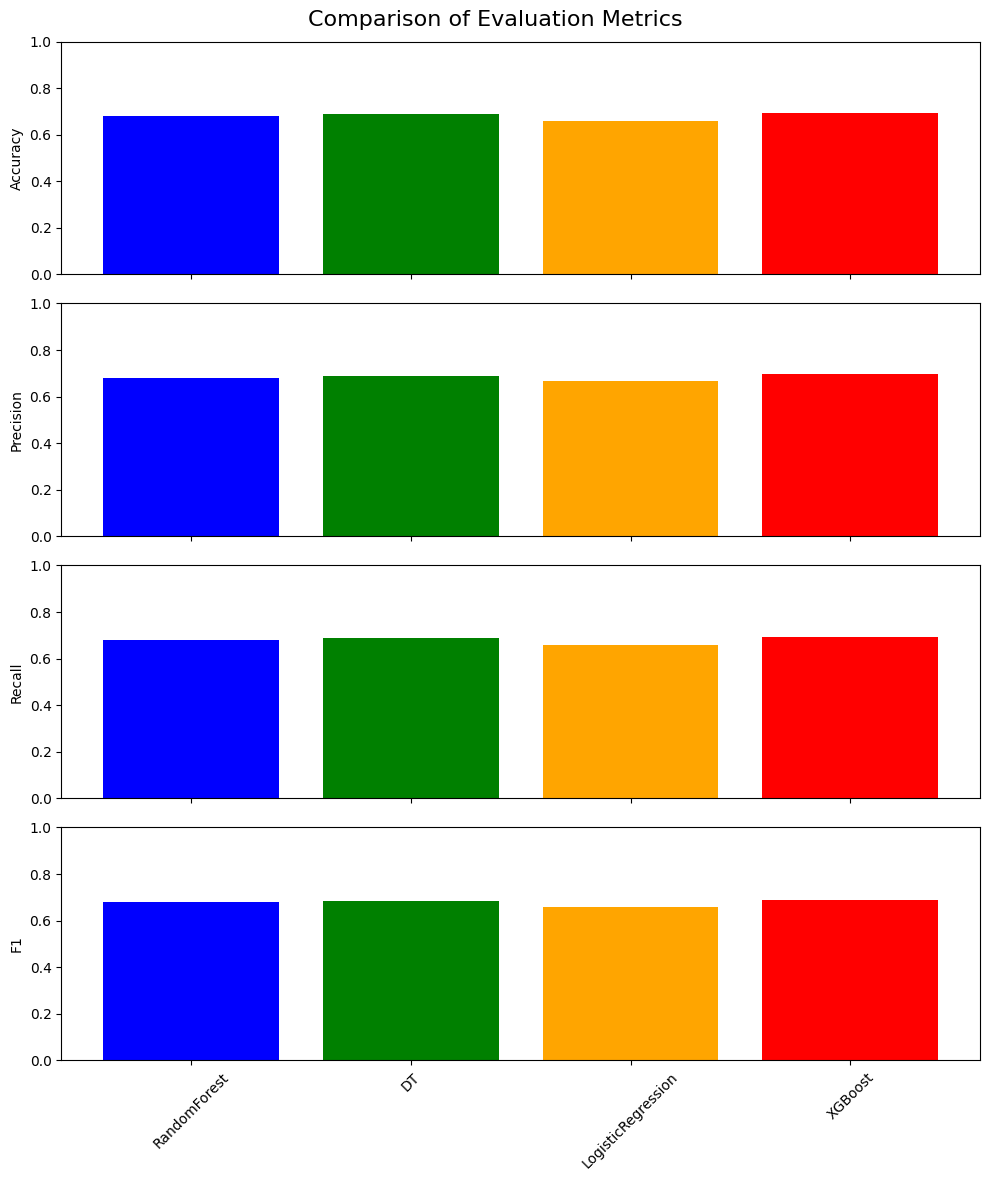

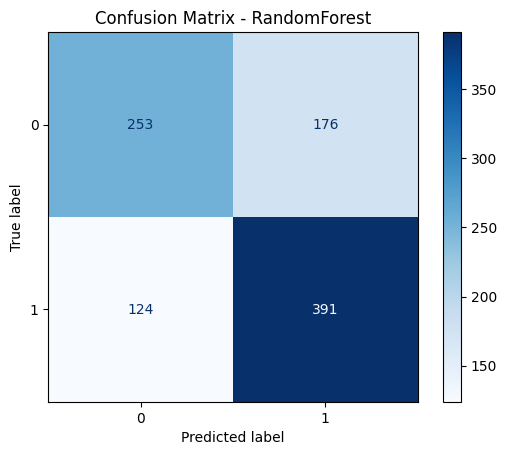

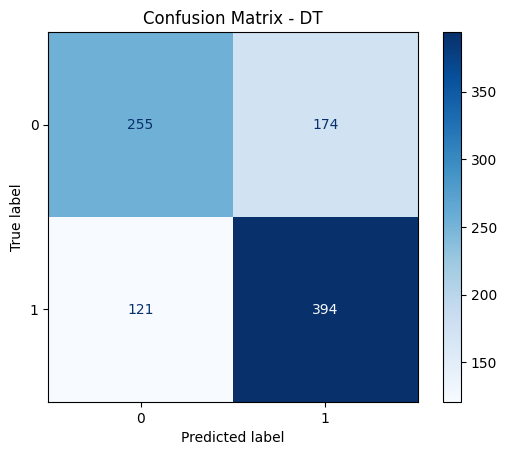

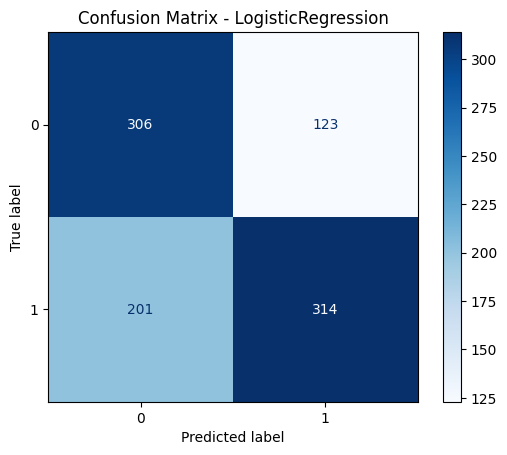

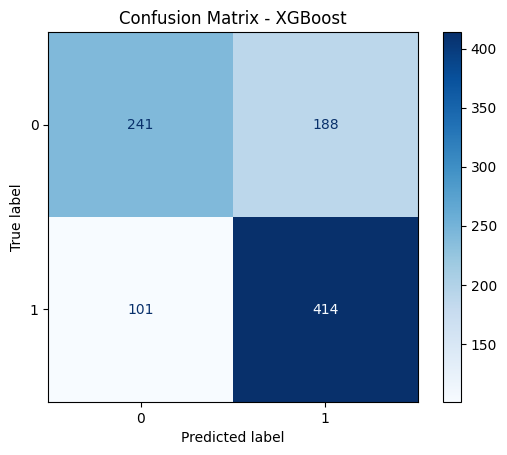

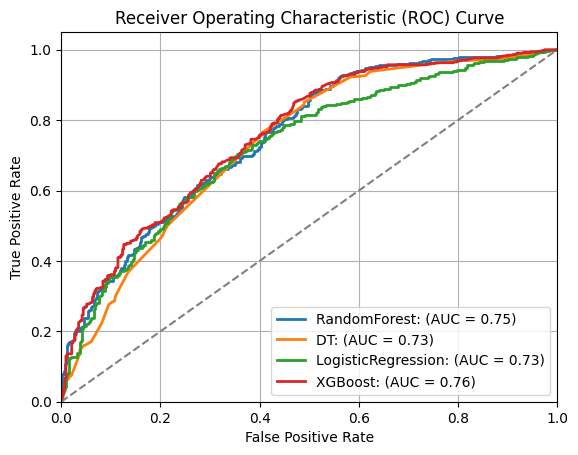

In [44]:
plot_metrics_comparison(results)
plot_confusion_matrices(results, X_test, y_test)
plot_roc_auc(results, X_test, y_test)

## Fixing high bias
- try adding polynomial features
- try adding additional features

### 1. Try Polynomial features

In [48]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = []

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode

X_train, X_test, y_train, y_test = preprocessing_dataframe(main_df, inputs)

X_train.head()

,budget,duration,years_since_release
981,0.508710,0.301280,-1.020781
2432,-0.726013,-0.645506,-0.452267
3072,-0.726013,0.585315,-0.289834
936,0.508710,-0.929542,-0.858348
1481,0.088904,-0.408810,-0.777132


In [53]:
poly = PolynomialFeatures(degree = 2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [56]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 200],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [None, 10, 15],
    'max_depth': [None, 6, 8]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)


In [57]:
# evaluating on train data
y_pred_train = trained_model.predict(X_train)
print(f"accuracy on train data: {accuracy_score(y_train, y_pred_train)}")
print('train data confusion matrix')
confusion_mat = confusion_matrix(y_train, y_pred_train)
print(confusion_mat)

# evaluating on test data
y_pred_test = trained_model.predict(X_test)
print(f"accuracy on test data: {accuracy_score(y_test, y_pred_test)}")
print('test data confusion matrix')
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

accuracy on train data: 0.7120890774125133
train data confusion matrix
[[ 994  786]
 [ 300 1692]]
accuracy on test data: 0.6917372881355932
test data confusion matrix


array([[231, 198],
       [ 93, 422]], dtype=int64)

In [58]:
# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest - Accuracy: 0.6917372881355932
RandomForest - Precision: 0.6953319588724864
RandomForest - Recall: 0.6917372881355932
RandomForest - F1-Score: 0.6845037158913068
RandomForest - Confusion Matrix:
[[231 198]
 [ 93 422]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6853813559322034
DT - Precision: 0.6872850055654182
DT - Recall: 0.6853813559322034
DT - F1-Score: 0.679078903525335
DT - Confusion Matrix:
[[233 196]
 [101 414]]

LogisticRegression - Best Parameters: {'C': 1, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.6588983050847458
LogisticRegression - Precision: 0.662193510719777
LogisticRegression - Recall: 0.6588983050847458
LogisticRegression - F1-Score: 0.6595892325858231
LogisticRegression 

### 2. adding additional feature using overview column

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

In [97]:
def preprocessing_dataframe_2(df, inputs):
    
    ##### drop nan values
    df.dropna(inplace=True)
    
    #### one hot encoding
    columns_to_encode = inputs.get('columns_to_dummies')
    df_onehot = pd.get_dummies(df, columns=columns_to_encode, dtype=int)
    df_onehot.head()
    
    #####
    encoder_list = inputs.get('label_encoder_list', None)
    if encoder_list:
        for col in encoder_list:
            # Initialize LabelEncoder
            label_encoder = LabelEncoder()

            # Fit and transform the 'decade' column
            df_onehot[col] = label_encoder.fit_transform(df_onehot[col])

    ##### making categorical list
    
    numerical_list = inputs.get('numerical_list')
    
    categorical_list = []
    for i in list(df_onehot.columns):
        if i not in numerical_list:
            categorical_list.append(i)
    
    ####
    for i in categorical_list:
        df_onehot[i] = df_onehot[i].astype('category')
    
    #### split data to train and test
    X = df_onehot.drop('profit_categorized', axis=1)
    y = df_onehot['profit_categorized']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    
    #### normalize numerical features
    
    # Initialize the scaler
    scaler = StandardScaler()  # or any other scaler you prefer

    # Fit and transform the training data
    X_train[numerical_list] = scaler.fit_transform(X_train[numerical_list])

    # Transform the test data using the scaler fitted on the training data
    X_test[numerical_list] = scaler.transform(X_test[numerical_list])
    
    return X_train, X_test, y_train, y_test
    

In [98]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', ]

df = main_df[features_list]

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = []

In [103]:
documents = main_df['overview'].fillna('')

In [104]:
documents

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4712    Friends/fledgling entrepreneurs invent a devic...
4713    El Mariachi just wants to play his guitar and ...
4714    "Signed, Sealed, Delivered" introduces a dedic...
4715    When ambitious New York attorney Sam is sent t...
4716    Ever since the second grade when he first saw ...
Name: overview, Length: 4717, dtype: object

In [105]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Additional stop words
custom_stopwords = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in custom_stopwords]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

# Preprocess each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100) # max_features=100

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
overview_features = vectorizer.fit_transform(preprocessed_documents)

# Convert the extracted features to a DataFrame
overview_features_df = pd.DataFrame(overview_features.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the features DataFrame with the original DataFrame
df_with_features = pd.concat([df, overview_features_df], axis=1)

In [106]:
df_with_features.head()

,budget,duration,profit_categorized,years_since_release,agent,american,attempt,battle,begin,best,boy,brother,child,city,come,couple,daughter,day,death,discover,discovers,dream,drug,earth,end,event,evil,face,fall,family,father,fight,film,force,forced,...,plan,police,power,relationship,return,save,school,secret,set,small,son,soon,star,start,stop,story,team,tell,thing,time,town,true,try,turn,wa,want,war,way,wife,woman,work,world,year,york,young
0,237.0,162.0,1,15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,300.0,169.0,1,17,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.53431,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.649552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,245.0,148.0,1,9,0.0,0.0,0.0,0.522378,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483889,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.473645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,250.0,165.0,1,12,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.657955,0.00000,0.0,0.0,0.0,0.340738,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.36695,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.277627,0.0,0.0
4,260.0,132.0,0,12,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380083,0.000000,0.0,0.0


In [107]:
inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode

X_train, X_test, y_train, y_test = preprocessing_dataframe_2(df_with_features, inputs)

X_train.head()

,budget,duration,years_since_release,agent,american,attempt,battle,begin,best,boy,brother,child,city,come,couple,daughter,day,death,discover,discovers,dream,drug,earth,end,event,evil,face,fall,family,father,fight,film,force,forced,friend,...,plan,police,power,relationship,return,save,school,secret,set,small,son,soon,star,start,stop,story,team,tell,thing,time,town,true,try,turn,wa,want,war,way,wife,woman,work,world,year,york,young
981,0.508710,0.301280,-1.020781,0.0,0.0,0.0,0.000000,0.0,0.250241,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.231037,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.390662,0.000000,0.0,0.0,0.0,0.0,0.190327,...,0.000000,0.262862,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.235661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256393,0.0,0.0,0.0,0.0,0.233915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198876,0.0,0.0
2432,-0.726013,-0.645506,-0.452267,0.0,0.0,0.0,0.336607,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.309168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.241076,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.594452,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3072,-0.726013,0.585315,-0.289834,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
936,0.508710,-0.929542,-0.858348,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.477962,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5053,0.509234,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1481,0.088904,-0.408810,-0.777132,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.654752,0.0,0.0,0.0,0.0,0.000000,...,0.755844,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [108]:
# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest - Accuracy: 0.690677966101695
RandomForest - Precision: 0.69216678589919
RandomForest - Recall: 0.690677966101695
RandomForest - F1-Score: 0.685176097060212
RandomForest - Confusion Matrix:
[[239 190]
 [102 413]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6970338983050848
DT - Precision: 0.703902886042194
DT - Recall: 0.6970338983050848
DT - F1-Score: 0.6879664119432163
DT - Confusion Matrix:
[[225 204]
 [ 82 433]]

LogisticRegression - Best Parameters: {'C': 0.1, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.6461864406779662
LogisticRegression - Precision: 0.6520729430646586
LogisticRegression - Recall: 0.6461864406779662
LogisticRegression - F1-Score: 0.6468541364121995
LogisticRegression

### 3. adding additional feature using director and actors column

In [110]:
df2 = main_df.copy()

In [111]:
#Replace NaN with an empty string
df2['director_name'] = df2['director_name'].fillna('')
df2['actor_1_name'] = df2['actor_1_name'].fillna('')
df2['actor_2_name'] = df2['actor_2_name'].fillna('')
df2['actor_3_name'] = df2['actor_3_name'].fillna('')

In [112]:
# Lowercase the strings and remove spaces
df2['director_name'] = df2['director_name'].str.lower().str.replace(' ', '')
df2['actor_1_name'] = df2['actor_1_name'].str.lower().str.replace(' ', '')
df2['actor_2_name'] = df2['actor_2_name'].str.lower().str.replace(' ', '')
df2['actor_3_name'] = df2['actor_3_name'].str.lower().str.replace(' ', '')

# Create a new column 'actors_and_director' by combining director and actors
df2['actors_and_director'] = df2['director_name'] + ' ' + df2['actor_1_name'] + ' ' + df2['actor_2_name'] + ' ' + df2['actor_3_name']

# Print the DataFrame to see the new column
df2.head()

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,budget_categorized,profit,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,other,year,years_since_release,decade,month,season,production_companies_list,actor_list,top actors,top_director,language_summarized,vote_average_categorized,actors_and_director
0,237.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787.965087,162.0,Enter the World of Pandora.,7.2,11800,United States of America,jamescameron,samworthington,zoesaldana,sigourneyweaver,high,2550.965087,1,True,True,False,False,False,False,False,True,False,False,False,True,False,False,2009,15,2000,12,winter,"['Ingenious Film Partners', 'Twentieth Century...","['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",0,0,English,popular,jamescameron samworthington zoesaldana sigourn...
1,300.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961.000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,United States of America,goreverbinski,johnnydepp,orlandobloom,keiraknightley,high,661.000000,1,True,True,False,False,False,False,False,True,False,False,False,False,False,False,2007,17,2000,5,spring,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...","['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",1,0,English,popular,goreverbinski johnnydepp orlandobloom keirakni...
2,245.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880.674609,148.0,A Plan No One Escapes,6.3,4466,United Kingdom,sammendes,danielcraig,christophwaltz,léaseydoux,high,635.674609,1,True,True,False,False,True,False,False,False,False,False,False,False,False,False,2015,9,2010,10,autumn,"['Columbia Pictures', 'Danjaq', 'B24']","['Daniel Craig', 'Christoph Waltz', 'Léa Seydo...",0,0,Not English,average,sammendes danielcraig christophwaltz léaseydoux
3,250.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084.939099,165.0,The Legend Ends,7.6,9106,United States of America,christophernolan,christianbale,michaelcaine,garyoldman,high,834.939099,1,True,False,False,False,True,True,False,False,False,False,False,False,True,False,2012,12,2010,7,summer,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...","['Christian Bale', 'Michael Caine', 'Gary Oldm...",0,0,English,popular,christophernolan christianbale michaelcaine ga...
4,260.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284.139100,132.0,"Lost in our world, found in another.",6.1,2124,United States of America,andrewstanton,taylorkitsch,lynncollins,samanthamorton,high,24.139100,0,True,True,False,False,False,False,False,False,False,False,False,True,False,False,2012,12,2010,3,spring,['Walt Disney Pictur

In [113]:
documents = df2['actors_and_director']

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

In [115]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=50) # max_features=100

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
overview_features = vectorizer.fit_transform(documents)

# Convert the extracted features to a DataFrame
overview_features_df = pd.DataFrame(overview_features.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the features DataFrame with the original DataFrame
df_with_features = pd.concat([df, overview_features_df], axis=1)

In [116]:
inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode

X_train, X_test, y_train, y_test = preprocessing_dataframe_2(df_with_features, inputs)

X_train.head()

,budget,duration,years_since_release,adamsandler,alecbaldwin,angelinajolie,anthonyhopkins,arnoldschwarzenegger,benstiller,bradpitt,brucewillis,camerondiaz,clinteastwood,denzelwashington,drewbarrymore,eddiemurphy,ewanmcgregor,georgeclooney,gerardbutler,harrisonford,jackson,jean,jimcarrey,johncusack,johnnydepp,johntravolta,juliannemoore,juliaroberts,kevincostner,liamneeson,markwahlberg,mattdamon,matthewmcconaughey,melgibson,merylstreep,morganfreeman,nicolascage,nicolekidman,owenwilson,piercebrosnan,robertdeniro,robinwilliams,russellcrowe,samuell,sandrabullock,seanconnery,stevenspielberg,sylvesterstallone,tomcruise,tomhanks,tommyleejones,willferrell,woodyallen
981,0.508710,0.301280,-1.020781,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432,-0.726013,-0.645506,-0.452267,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3072,-0.726013,0.585315,-0.289834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
936,0.508710,-0.929542,-0.858348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1481,0.088904,-0.408810,-0.777132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [117]:
# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
RandomForest - Accuracy: 0.7002118644067796
RandomForest - Precision: 0.7076054034865101
RandomForest - Recall: 0.7002118644067796
RandomForest - F1-Score: 0.6911179849657534
RandomForest - Confusion Matrix:
[[226 203]
 [ 80 435]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6896186440677966
DT - Precision: 0.6894144966564111
DT - Recall: 0.6896186440677966
DT - F1-Score: 0.6859519156155748
DT - Confusion Matrix:
[[249 180]
 [113 402]]

LogisticRegression - Best Parameters: {'C': 0.1, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.659957627118644
LogisticRegression - Precision: 0.6672731440182377
LogisticRegression - Recall: 0.659957627118644
LogisticRegression - F1-Score: 0.6604787458393994
LogisticRegres

## 4. using PCA

In [30]:
main_df.columns

Index(['budget', 'genres', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration', 'tagline',
       'vote_average', 'num_voted_users', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'budget_categorized',
       'profit', 'profit_categorized', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'other', 'year',
       'years_since_release', 'decade', 'month', 'season',
       'production_companies_list', 'actor_list', 'top actors', 'top_director',
       'language_summarized', 'vote_average_categorized'],
      dtype='object')

In [47]:
from sklearn.decomposition import PCA


In [90]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', 'top_director', 'top actors', 'season']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = ['season']

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode


X_train, X_test, y_train, y_test = preprocessing_dataframe(main_df, inputs)

X_train.head()

,budget,duration,years_since_release,top_director,top actors,season_autumn,season_spring,season_summer,season_winter
981,0.508710,0.301280,-1.020781,0,0,0,1,0,0
2432,-0.726013,-0.645506,-0.452267,0,0,0,0,0,1
3072,-0.726013,0.585315,-0.289834,0,0,0,1,0,0
936,0.508710,-0.929542,-0.858348,0,0,0,0,0,1
1481,0.088904,-0.408810,-0.777132,0,0,0,0,1,0


In [91]:
y_train.shape

(3772,)

In [92]:
# Apply PCA
pca = PCA(n_components=3)  # You can adjust the number of components as needed
pca_features = pca.fit_transform(X_train[numerical_list])

# Convert PCA features to DataFrame
pca_features_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2', 'PCA3'])

# Concatenate PCA features DataFrame with original DataFrame
X_train_with_pca = pd.concat([X_train.reset_index(), pca_features_df], axis=1)

X_train_with_pca.drop(numerical_list, axis=1, inplace=True)

In [93]:
pca_features_df.shape

(3772, 3)

In [94]:
X_train.shape

(3772, 9)

In [95]:
X_train_with_pca.shape

(3772, 10)

In [96]:
# Apply PCA
pca_features = pca.transform(X_test[numerical_list])

# Convert PCA features to DataFrame
pca_features_df = pd.DataFrame(data=pca_features, columns=['PCA1', 'PCA2', 'PCA3'])

# Concatenate PCA features DataFrame with original DataFrame
X_test_with_pca = pd.concat([X_test.reset_index(), pca_features_df], axis=1)

X_test_with_pca.drop(numerical_list, axis=1, inplace=True)

In [97]:
X_test_with_pca.shape

(944, 10)

In [98]:

# compare diffrent models

# models dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(solver='saga', random_state=42),
    'XGBoost': XGBClassifier(random_state=42, enable_categorical=True)
}

# param_grids dictionary
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 80, 200],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'DT': {
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [None, 10, 15],
        'max_depth': [None, 6, 8]
    },
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.1, 10, 100]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [6, 8, 10]
    }
}

# Example usage:
results = evaluate_models(models, param_grids, X_train_with_pca, X_test_with_pca, y_train, y_test)

# Print results
for name, result in results.items():
    print(f"{name} - Best Parameters: {result['params']}")
    print(f"{name} - Accuracy: {result['accuracy']}")
    print(f"{name} - Precision: {result['precision']}")
    print(f"{name} - Recall: {result['recall']}")
    print(f"{name} - F1-Score: {result['f1']}")
    print(f"{name} - Confusion Matrix:\n{result['confusion_matrix']}\n")

    


Evaluating RandomForest...
Evaluating DT...
Evaluating LogisticRegression...
Evaluating XGBoost...
RandomForest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 80}
RandomForest - Accuracy: 0.6790254237288136
RandomForest - Precision: 0.6781228565832602
RandomForest - Recall: 0.6790254237288136
RandomForest - F1-Score: 0.6782978515479624
RandomForest - Confusion Matrix:
[[268 161]
 [142 373]]

DT - Best Parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10}
DT - Accuracy: 0.6557203389830508
DT - Precision: 0.6557880240150059
DT - Recall: 0.6557203389830508
DT - F1-Score: 0.6557534461297958
DT - Confusion Matrix:
[[267 162]
 [163 352]]

LogisticRegression - Best Parameters: {'C': 0.001, 'penalty': 'l2'}
LogisticRegression - Accuracy: 0.4830508474576271
LogisticRegression - Precision: 0.6842714652312321
LogisticRegression - Recall: 0.4830508474576271
LogisticRegression - F1-Score: 0.3517050276749375
LogisticReg

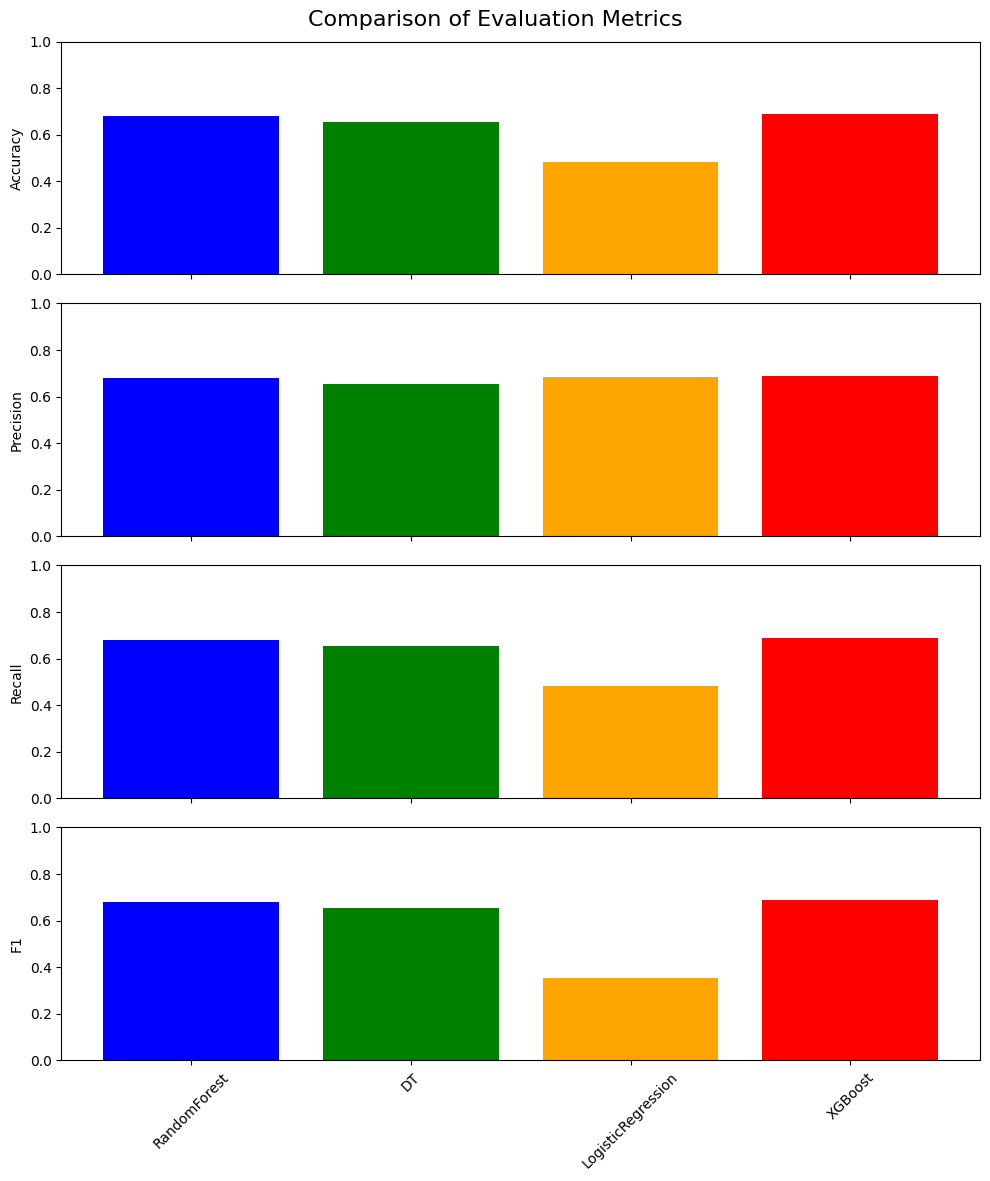

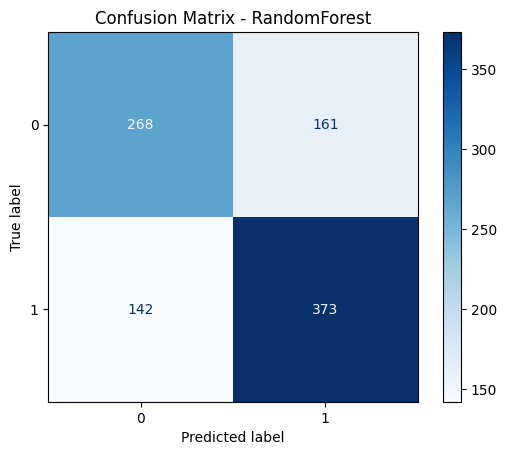

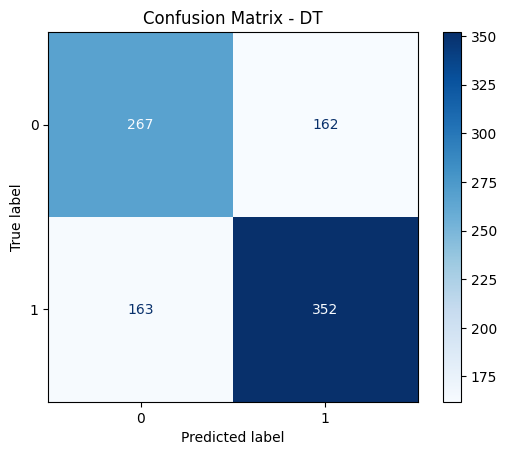

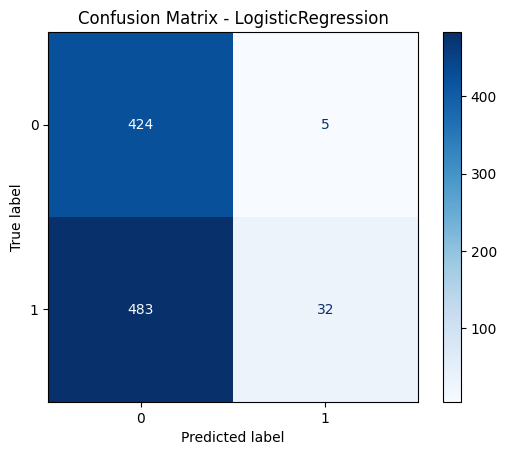

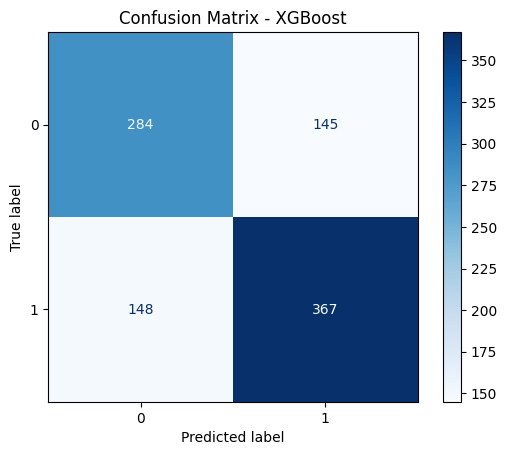

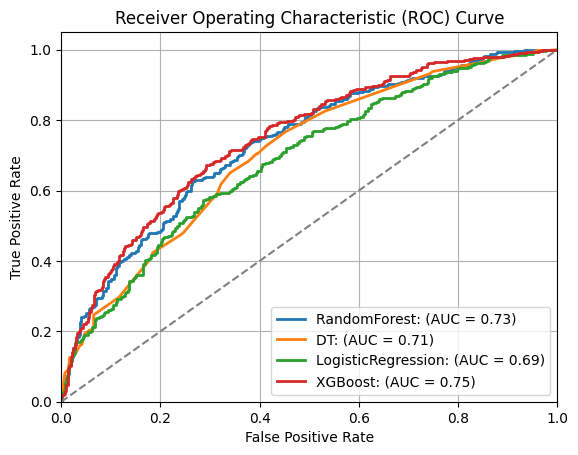

In [99]:
plot_metrics_comparison(results)
plot_confusion_matrices(results, X_test, y_test)
plot_roc_auc(results, X_test, y_test)

# Error analysis

In [107]:
def preprocessing_dataframe_3(main_df, inputs):
    
    ##### drop extra fatures
    features_list = inputs['features_list']
    df = main_df[features_list]
    
    ##### drop nan values
    df.dropna(inplace=True)
    
    #### one hot encoding
    columns_to_encode = inputs.get('columns_to_dummies')
    df_onehot = pd.get_dummies(df, columns=columns_to_encode, dtype=int)
    df_onehot.head()
    
    #####
    encoder_list = inputs.get('label_encoder_list', None)
    if encoder_list:
        for col in encoder_list:
            # Initialize LabelEncoder
            label_encoder = LabelEncoder()

            # Fit and transform the 'decade' column
            df_onehot[col] = label_encoder.fit_transform(df_onehot[col])

    ##### making categorical list
    
    numerical_list = inputs.get('numerical_list')
    
    categorical_list = []
    for i in list(df_onehot.columns):
        if i not in numerical_list:
            categorical_list.append(i)
    
    ####
    for i in categorical_list:
        df_onehot[i] = df_onehot[i].astype('category')
    
    #### split data to train and test
    X = df_onehot.drop('profit_categorized', axis=1)
    y = df_onehot['profit_categorized']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
    
    #### normalize numerical features
    
    # Initialize the scaler
    scaler = StandardScaler()  # or any other scaler you prefer

    # Fit and transform the training data
    X_train[numerical_list] = scaler.fit_transform(X_train[numerical_list])

    # Transform the test data using the scaler fitted on the training data
    X_test[numerical_list] = scaler.transform(X_test[numerical_list])
    
    return X_train, X_test, y_train, y_test, scaler
    

In [108]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', 'decade', 'season',
                 'top actors', 'top_director', 'language_summarized']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = ['decade', 'season']

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode
inputs['label_encoder_list'] = ['language_summarized']

X_train, X_test, y_train, y_test, scaler = preprocessing_dataframe_3(main_df, inputs)

X_train.head()

,budget,duration,years_since_release,top actors,top_director,language_summarized,decade_1980,decade_1990,decade_2000,decade_2010,decade_befor 1980,season_autumn,season_spring,season_summer,season_winter
981,0.508710,0.301280,-1.020781,0,0,0,0,0,0,1,0,0,1,0,0
2432,-0.726013,-0.645506,-0.452267,0,0,0,0,0,1,0,0,0,0,0,1
3072,-0.726013,0.585315,-0.289834,0,0,0,0,0,1,0,0,0,1,0,0
936,0.508710,-0.929542,-0.858348,0,0,0,0,0,0,1,0,0,0,0,1
1481,0.088904,-0.408810,-0.777132,0,0,0,0,0,0,1,0,0,0,1,0


In [109]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 200],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [None, 10, 15],
    'max_depth': [None, 6, 8]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)


In [110]:
# evaluating on train data
y_pred_train = trained_model.predict(X_train)
print(f"accuracy on train data: {accuracy_score(y_train, y_pred_train)}")
print('train data confusion matrix')
confusion_mat = confusion_matrix(y_train, y_pred_train)
print(confusion_mat)

# evaluating on test data
y_pred_test = trained_model.predict(X_test)
print(f"accuracy on test data: {accuracy_score(y_test, y_pred_test)}")
print('test data confusion matrix')
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

accuracy on train data: 0.7643160127253447
train data confusion matrix
[[1213  567]
 [ 322 1670]]
accuracy on test data: 0.6822033898305084
test data confusion matrix


array([[253, 176],
       [124, 391]], dtype=int64)

In [111]:
# Run the trained model on the test set
predictions = trained_model.predict(X_test)

# Compare predictions with ground truth labels
misclassifications = (predictions != y_test)

# Get misclassified samples
misclassified_samples = X_test[misclassifications]

misclassified_samples_y = y_test[misclassifications]

misclassified_samples[numerical_list] = scaler.inverse_transform(misclassified_samples[numerical_list])



# Run the trained model on the test set
predictions = trained_model.predict(X_train)

# Compare predictions with ground truth labels
misclassifications_train = (predictions != y_train)

# Get misclassified samples
misclassified_samples_train = X_train[misclassifications_train]

misclassified_samples_train_y = y_train[misclassifications_train]

misclassified_samples_train[numerical_list] = scaler.inverse_transform(misclassified_samples_train[numerical_list])


In [114]:
misclassified_samples_train.columns

Index(['budget', 'duration', 'years_since_release', 'top actors',
       'top_director', 'language_summarized', 'decade_1980', 'decade_1990',
       'decade_2000', 'decade_2010', 'decade_befor 1980', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')

<Axes: xlabel='budget', ylabel='duration'>

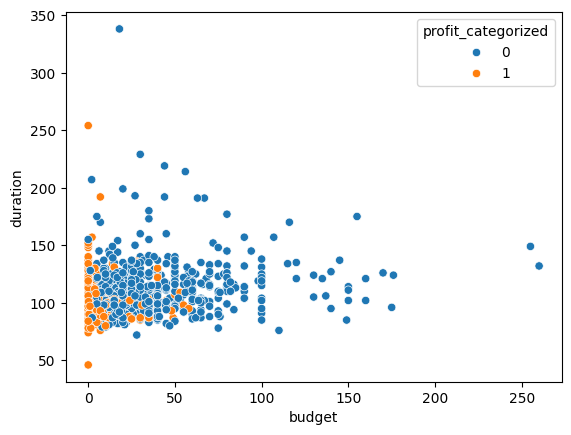

In [115]:
sns.scatterplot(misclassified_samples_train, x='budget', y='duration', hue=misclassified_samples_train_y)

<Axes: xlabel='years_since_release', ylabel='duration'>

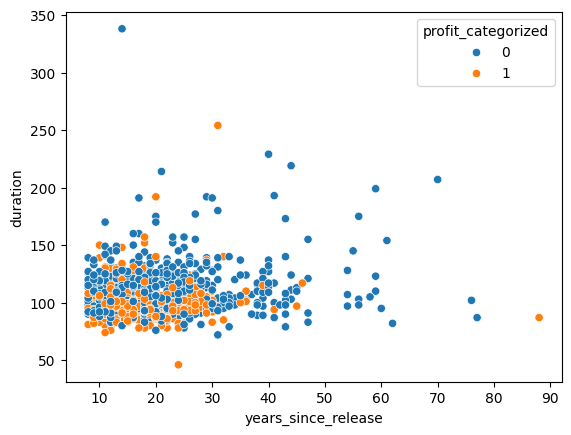

In [129]:

sns.scatterplot(misclassified_samples_train, x='years_since_release', y='duration', hue=misclassified_samples_train_y)

<Axes: xlabel='duration', ylabel='Count'>

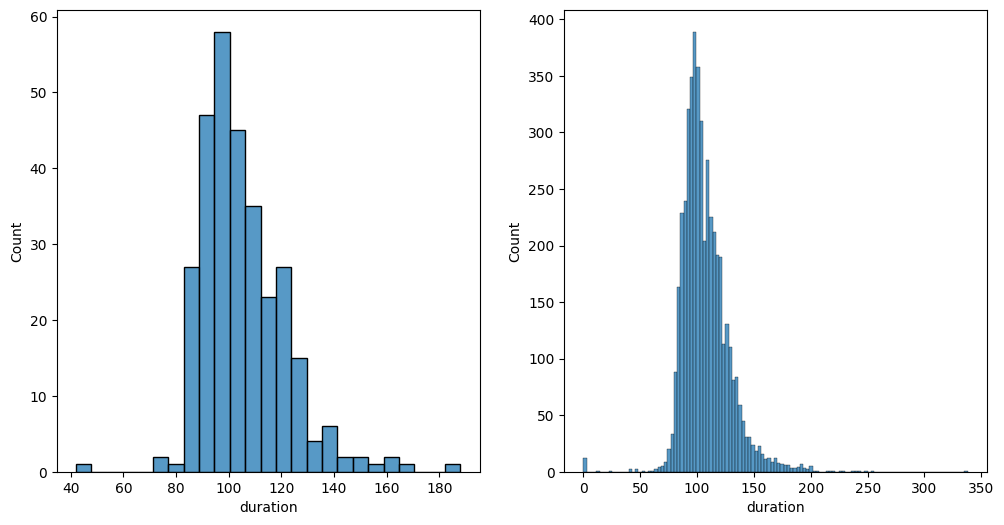

In [113]:
ff = 'duration'

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(data=misclassified_samples, x=ff)
plt.subplot(1,2,2)
sns.histplot(data=main_df, x=ff)


In [ ]:
ff = 'duration'

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(data=misclassified_samples, x=ff)
plt.subplot(1,2,2)
sns.histplot(data=main_df, x=ff)


## preprocessing testing

In [118]:
main_df_2 = main_df.copy()

In [119]:
# main_df_2['profit_categorized'] = np.where(main_df_2['profit'] > 0, 'profit', 'no profit')

In [137]:
df_preprocessed = main_df.copy()

In [138]:
# remove data budget & gross = 0

df_preprocessed = df_preprocessed[df_preprocessed['budget'] != 0]
df_preprocessed = df_preprocessed[df_preprocessed['gross'] != 0]


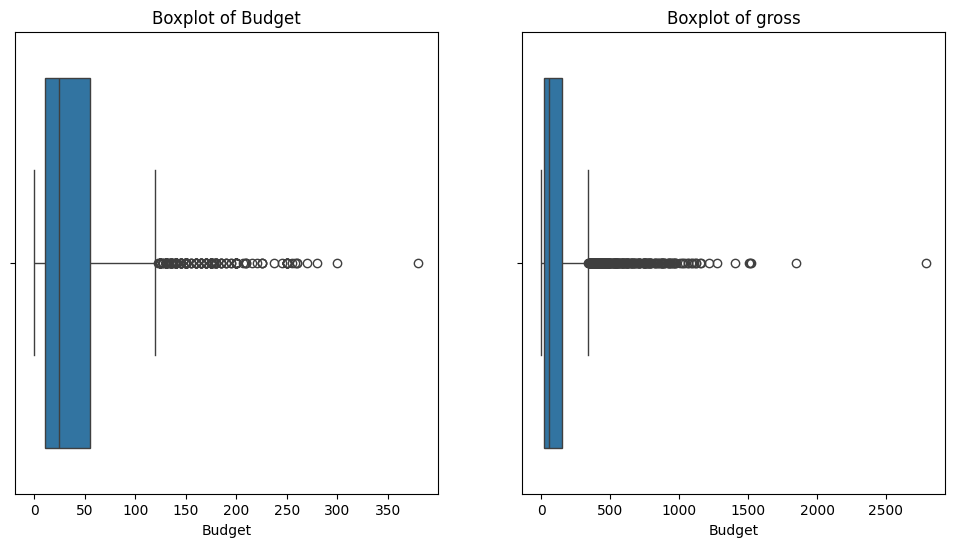

In [139]:
# Plot boxplot to visualize outliers in the 'budget' column
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

sns.boxplot(x=df_preprocessed['budget'])
plt.title('Boxplot of Budget')
plt.xlabel('Budget')


plt.subplot(1,2,2)

sns.boxplot(x=df_preprocessed['gross'])
plt.title('Boxplot of gross')
plt.xlabel('Budget')
plt.show()

In [140]:
df_preprocessed['profit_categorized'].value_counts()

profit_categorized
1    2363
0     859
Name: count, dtype: int64

In [148]:
df_preprocessed.columns

Index(['budget', 'genres', 'plot_keywords', 'language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'gross', 'duration', 'tagline',
       'vote_average', 'num_voted_users', 'country', 'director_name',
       'actor_1_name', 'actor_2_name', 'actor_3_name', 'budget_categorized',
       'profit', 'profit_categorized', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'other', 'year',
       'years_since_release', 'decade', 'month', 'season',
       'production_companies_list', 'actor_list', 'top actors', 'top_director',
       'language_summarized', 'vote_average_categorized'],
      dtype='object')

In [149]:
# preprocessing
features_list = ['budget', 'duration', 'profit_categorized', 'years_since_release', 'top actors', 'top_director']

numerical_list = ['budget', 'duration', 'years_since_release']
columns_to_encode = []

inputs = dict()
inputs['features_list'] = features_list
inputs['numerical_list'] = numerical_list
inputs['columns_to_dummies'] = columns_to_encode


In [173]:
##### drop extra fatures
features_list = inputs['features_list']
df = df_preprocessed[features_list]


In [174]:
df['profit_categorized'].value_counts()

profit_categorized
1    2363
0     859
Name: count, dtype: int64

In [175]:

##### drop nan values
df.dropna(inplace=True)

#### one hot encoding
columns_to_encode = inputs.get('columns_to_dummies')
df_onehot = pd.get_dummies(df, columns=columns_to_encode, dtype=int)
df_onehot.head()

#####
encoder_list = inputs.get('label_encoder_list', None)
if encoder_list:
    for col in encoder_list:
        # Initialize LabelEncoder
        label_encoder = LabelEncoder()

        # Fit and transform the 'decade' column
        df_onehot[col] = label_encoder.fit_transform(df_onehot[col])

##### making categorical list

numerical_list = inputs.get('numerical_list')

categorical_list = []
for i in list(df_onehot.columns):
    if i not in numerical_list:
        categorical_list.append(i)

####
for i in categorical_list:
    df_onehot[i] = df_onehot[i].astype('category')


### Downsampling

In [177]:
class_0_count = 700
class_1_count = 700

df=df_onehot.copy()
target_col='profit_categorized'

# Separate data by class
noprofit_data = df[df[target_col] == 0].sample(n=class_0_count, random_state=42)
profit_data = df[df[target_col] == 1].sample(n=class_1_count, random_state=42)


# Combine data from each class into training data
downsampled_train_data = pd.concat([noprofit_data, profit_data])

# Remove training data from original data to create testing data
downsampled_test_data = df.drop(downsampled_train_data.index)

In [178]:
# Separate features and target variable
X_train = downsampled_train_data.drop([target_col], axis=1)
y_train = downsampled_train_data[target_col]

X_test = test_data.drop([target_col], axis=1)
y_test = test_data[target_col]

In [179]:
y_train.value_counts()

profit_categorized
0    700
1    700
Name: count, dtype: int64

In [180]:
poly = PolynomialFeatures(degree = 2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [181]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 200],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [None, 10, 15],
    'max_depth': [None, 6, 8]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)


In [182]:
# evaluating on train data
y_pred_train = trained_model.predict(X_train)
print(f"accuracy on train data: {accuracy_score(y_train, y_pred_train)}")
print('train data confusion matrix')
confusion_mat = confusion_matrix(y_train, y_pred_train)
print(confusion_mat)

# evaluating on test data
y_pred_test = trained_model.predict(X_test)
print(f"accuracy on test data: {accuracy_score(y_test, y_pred_test)}")
print('test data confusion matrix')
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

accuracy on train data: 0.6657142857142857
train data confusion matrix
[[595 105]
 [363 337]]
accuracy on test data: 0.7465277777777778
test data confusion matrix


array([[1300,  209],
       [ 302,  205]], dtype=int64)

### Upsampling

In [183]:
df_onehot['profit_categorized'].value_counts()

profit_categorized
1    2363
0     859
Name: count, dtype: int64

In [191]:
class_0_count = 700
class_1_count = 1200

df=df_onehot.copy()
target_col='profit_categorized'

# Separate data by class
noprofit_data = df[df[target_col] == 0].sample(n=class_0_count, random_state=42)
profit_data = df[df[target_col] == 1].sample(n=class_1_count, random_state=42)


# Combine data from each class into training data
train_data = pd.concat([noprofit_data, profit_data])

# Remove training data from original data to create testing data
test_data = df.drop(train_data.index)

In [192]:
test_data['profit_categorized'].value_counts()

profit_categorized
1    1163
0     159
Name: count, dtype: int64

In [193]:
from sklearn.utils import resample

# Upsample the minority class (1) to match the count of the majority class (0)


# Separate majority and minority classes
class_0 = train_data[train_data['profit_categorized'] == 0]
class_1 = train_data[train_data['profit_categorized'] == 1]

# Upsample minority class
class_0_upsampled = resample(class_0,
                             replace=True,  # Sample with replacement
                             n_samples=class_1_count,  # Match the count of majority class
                             random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
upsampled_train_data = pd.concat([class_1, class_0_upsampled])


In [194]:
# Separate features and target variable
X_train = upsampled_train_data.drop([target_col], axis=1)
y_train = upsampled_train_data[target_col]

X_test = test_data.drop([target_col], axis=1)
y_test = test_data[target_col]

In [195]:
y_test.value_counts()

profit_categorized
1    1163
0     159
Name: count, dtype: int64

In [196]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 80, 150],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [None, 10, 15, 20],
    'max_depth': [None, 6, 10, 15]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

best_params = tune_hyperparameters(rf, param_grid, X_train, y_train)
trained_model = train_model(rf, best_params, X_train, y_train)


In [197]:
# evaluating on train data
y_pred_train = trained_model.predict(X_train)
print(f"accuracy on train data: {accuracy_score(y_train, y_pred_train)}")
print('train data confusion matrix')
confusion_mat = confusion_matrix(y_train, y_pred_train)
print(confusion_mat)

# evaluating on test data
y_pred_test = trained_model.predict(X_test)
print(f"accuracy on test data: {accuracy_score(y_test, y_pred_test)}")
print('test data confusion matrix')
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

accuracy on train data: 0.7908333333333334
train data confusion matrix
[[1013  187]
 [ 315  885]]
accuracy on test data: 0.6013615733736762
test data confusion matrix


array([[ 89,  70],
       [457, 706]], dtype=int64)